In [1]:
# UOC
# Grado de Ingeniería Informática
# Inteligencia Artificial
# TFG - Aplicación de Técnicas de Explicabilidad (XAI) y Cuantificación de Incertidumbre (UQ) en la Predicción del Síndrome Metabólico mediante Aprendizaje Automático
# Xema Belmonte Marín

# Análisis exploratorio y limpieza de los datos

En este cuaderno realizaremos la EDA (*Exploratory Data Analysis*) del conjunto de datos que usaremos para la posterior tarea supervisada de clasificación binaria. Con la ayuda de herramientas de visualización, observaremos el tipo de distribuciones que tenemos en nuestros datos y las correlaciones entre distintos atributos. Este proceso se acompañará con algunas tareas de limpieza y acondicionamiento de los datos.

## Librerías y funciones

### Import libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn: exploración de los datos
from sklearn.metrics import mutual_info_score, roc_auc_score

%matplotlib inline

### Funciones

In [3]:
# Opciones generales

# Desactivar warnings
warnings.filterwarnings("ignore")

# Mostramos dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Tamaño de letra en los gráficos
font = {'size': 12}
plt.rc('font', **font)

In [4]:
def load_and_info(file_path):
    """
    Cargamos el fichero CSV y mostramos información sobre valores ausentes, únicos, tipo de datos y valores
    """
    df = pd.read_csv(file_path)
    
    info = []
    for col in df.columns:
        data_type = str(df[col].dtype)
        missing = np.sum(pd.isna(df[col]))
        unique = df[col].nunique()
        
        # Obtenemos las categorías para variables categoricas y valores aleatorios en las numéricas
        if data_type == 'object':
            sample = df[col].dropna().unique().tolist()  # Valores únicos para las categóricas
        else:
            sample = df[col].dropna().unique()[:5].tolist()  # Los primeros 5 valores únicos para las numéricas
        
        info.append([col, data_type, missing, unique, sample])
    
    info_df = pd.DataFrame(info)
    info_df.columns = ['Column', 'Dtype', 'Missing', 'Unique', 'Sample values']
    
    # Mostramos las columnas, con información sobre valores ausentes, únicos y tipo de datos
    display(info_df)
    print("\nEl juego de datos contiene {} variables y {} observaciones, de las cuales {} son duplicadas.".format(df.shape[1], df.shape[0], len(df) - df.duplicated().count()))

    # Devolvemos el dataframe para su uso
    return df

In [5]:
def display_categorical(feature, target='MetabolicSyndrome'):
    """
    Para variables categóricas: pie chart y bar chart
    """
    # Gráficas en una fila con dos columnas, siendo el segundo plot 1,5 veces mas ancho
    fig, axs = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios':[1,1.5]})

    value_counts = df[feature].value_counts()
    colors = ['#ABC875', '#D75C58']

    axs[0].pie(
        value_counts.values,
        labels=value_counts.index,
        explode=([0.05]*len(value_counts.index)),
        autopct='%.2f%%',
        colors=['#D3D3D3']
    )

    if feature == target:
        axs[1].barh(
            y=value_counts.index.astype(str),
            width=value_counts.values,
            color=colors[:len(value_counts.index)]
        )
        axs[1].set_xlabel('Data count')
        axs[1].grid(alpha=0.4)
        
        for index, values in enumerate(value_counts):
            axs[1].text(values + 5, index, str(values), va='center')
    
    else:
        # Mostramos la distribución del bar chart por la variable target
        sns.histplot(
            data=df,
            y=feature,
            hue=target,
            multiple="fill",
            shrink=0.8,
            palette=colors,
            ax=axs[1]
        )
        axs[1].set_ylabel(feature)
        axs[1].set_xlabel('Proportion')
        axs[1].grid(alpha=0.4)

    fig.suptitle('Distribución de la variable ' + feature)
    plt.tight_layout(pad=1)
    plt.show()

In [6]:
def display_numerical(feature):
    """
    Para variables numéricas: histograma, boxplot y tabla descriptiva
    """
    fig, axs = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios':[1.5,1]})

    colors = ['#ABC875', '#D75C58']

    sns.histplot(data=df,
                 x=df[feature],
                 hue=df['MetabolicSyndrome'],
                 palette=colors,
                 multiple='stack',
                 ax=axs[0])
    axs[0].grid(alpha=0.4)
    
    sns.boxplot(data=df,
                x=df['MetabolicSyndrome'],
                y=df[feature],
                hue='MetabolicSyndrome',
                palette=colors,
                ax=axs[1])
    axs[1].grid(alpha=0.4)
    axs[1].legend_.remove()  # Eliminamos la leyenda del boxplot
    
    fig.suptitle(f'Síndrome metabólico para la distribución de la variable {feature}')
    plt.tight_layout(pad=1)
    plt.show()

    # Mostramos las estadísticas de la característica agrupada por la variable objetivo
    display(df.groupby('MetabolicSyndrome')[feature].describe())

## Análisis exploratorio de los datos (DEA)

In [7]:
df = load_and_info('metabolic_syndrome.csv')

Column    Dtype  Missing  Unique  \
0                seqn    int64        0    2401   
1                 Age    int64        0      61   
2                 Sex   object        0       2   
3             Marital   object      208       5   
4              Income  float64      117      14   
5                Race   object        0       6   
6           WaistCirc  float64       85     635   
7                 BMI  float64       26     322   
8         Albuminuria    int64        0       3   
9             UrAlbCr  float64        0    1383   
10           UricAcid  float64        0      88   
11       BloodGlucose    int64        0     187   
12                HDL    int64        0      93   
13      Triglycerides    int64        0     345   
14  MetabolicSyndrome    int64        0       2   

                                        Sample values  
0                 [62161, 62164, 62169, 62172, 62177]  
1                                [22, 44, 21, 43, 51]  
2                                      [Male, Female]  
3     [Single, Married, Widowed, Divorced, Separated]  
4              [8200.0, 4500.0, 800.0, 2000.0, 300.0]  
5   [White, Asian, Black, MexAmerican, Hispanic, O...  
6                     [81.0, 80.1, 69.6, 120.4, 81.1]  
7                      [23.3, 23.2, 20.1, 33.3, 28.5]  
8                                           [0, 1, 2]  
9                      [3.88, 8.55, 5.07, 5.22, 8.13]  
10                          [4.9, 4.5, 5.4, 5.0, 4.8]  
11                             [92, 82, 107, 104, 95]  
12                               [41, 28, 43, 73, 47]  
13                             [84, 56, 78, 141, 126]  
14                                             [0, 1]


El juego de datos contiene 15 variables y 2401 observaciones, de las cuales 0 son duplicadas.


Organizamos lógicamente las 15 variables y disponemos de un diccionario de datos para comprender lo que representa cada atributo en el conjunto de datos:

- **seqn** número identificador de la secuencia (paciente)

Atributos demográficos

- **Age** edad de la persona
- **Sex** género
- **Marital** estado civil
- **Income** nivel de ingresos o información relacionada con los ingresos
- **Race** raza o etnia de la persona

Atributos clínicos

- **WaistCirc** medida de la circunferencia de la cintura
- **BMI** índice de masa corporal (*Body Mass Index*)
- **Albuminuria** albúmina en orina
- **UrAlbCr** relación albúmina-creatinina en orina
- **UricAcid** ácido úrico en sangre
- **BloodGlucose** azúcar en sangre
- **HDL** colesterol “bueno” en sangre
- **Triglycerides** triglicéridos en sangre

Variable objetivo

- **MetabolicSyndrome** variable binaria que indica la presencia (1) o ausencia (0) de síndrome metabólico

In [8]:
df.describe().T

count      mean      std       min       25%       50%  \
seqn              2,401.00 67,030.67 2,823.57 62,161.00 64,591.00 67,059.00   
Age               2,401.00     48.69    17.63     20.00     34.00     48.00   
Income            2,284.00  4,005.25 2,954.03    300.00  1,600.00  2,500.00   
WaistCirc         2,316.00     98.31    16.25     56.20     86.67     97.00   
BMI               2,375.00     28.70     6.66     13.40     24.00     27.70   
Albuminuria       2,401.00      0.15     0.42      0.00      0.00      0.00   
UrAlbCr           2,401.00     43.63   258.27      1.40      4.45      7.07   
UricAcid          2,401.00      5.49     1.44      1.80      4.50      5.40   
BloodGlucose      2,401.00    108.25    34.82     39.00     92.00     99.00   
HDL               2,401.00     53.37    15.19     14.00     43.00     51.00   
Triglycerides     2,401.00    128.13    95.32     26.00     75.00    103.00   
MetabolicSyndrome 2,401.00      0.34     0.47      0.00      0.00      0.00   

                        75%       max  
seqn              69,495.00 71,915.00  
Age                   63.00     80.00  
Income             6,200.00  9,000.00  
WaistCirc            107.62    176.00  
BMI                   32.10     68.70  
Albuminuria            0.00      2.00  
UrAlbCr               13.69  5,928.00  
UricAcid               6.40     11.30  
BloodGlucose         110.00    382.00  
HDL                   62.00    156.00  
Triglycerides        150.00  1,562.00  
MetabolicSyndrome      1.00      1.00

Disponemos de un juego de datos con 15 variables y 2401 observaciones (pacientes). De las 15 variables de cada observación, tres son categóricas y describen datos demográficos de las personas, como el sexo, el estado civil y el grupo étnico al que pertenecen. También se incluyen los ingresos y la edad. Se dispone además de 8 variables numéricas con marcadores sobre los análisis clínicos realizados y, asociada a éstos, una variable *target* binaria. Además, es fácil reconocer qué representa cada columna y no contiene duplicados. Sin embargo, las variables demográficas *Marital*, que indica el estado civil, e *Income*, para los ingresos, contienen unos centenares de casos ausentes que habrá que tratar. En cuanto a la dimensión clínica, a excepción de *WaistCirc* y *BMI*, el resto de marcadores están completos para todas las observaciones.

Vemos que se recogen datos para personas en un rango de edad de entre 20 y 80 años (estando la media en los 48). El nivel de ingresos medio (en dólares), que vamos a considerar como mensuales, es de 4000, con un primer cuartil de 1600. Los marcadores clínicos muestran unos rangos de valores que a veces son bastante distantes, como en los casos de *UrAlbCr* o *Triglycerides* donde el tercer cuartil es ya de por sí un número bastante distante de los respectivos máximos, pudiendo representar la presencia de *outliers*. Las variables *Albuminuria* y *MetabolicSyndrome* tienen un carácter categórico. En el caso de esta última, que es la variable objetivo, define de forma binaria el diagnóstico de cada persona. Sin embargo, para la primera necesitaremos profundizar en ella para poder interpretarla como variable cualitativa.

Eliminamos la columna *seqn*, ya que representa un ID y no aporta información:

In [9]:
# Eliminamos variable seqn
df.drop('seqn', axis=1, inplace=True)

In [10]:
df.describe(include = ['O'])

Sex  Marital   Race
count     2401     2193   2401
unique       2        5      6
top     Female  Married  White
freq      1211     1192    933

Podemos ahora observar como los géneros están representados prácticamente por igual en el *dataset* (hay ligeramente más mujeres) y un poco más de la mitad de las personas están casadas, aunque en 208 casos el estado civil está sin determinar. Más adelante examinaremos la representación étnica, que indica que la mayoría está compuesta por una población blanca.

### Distribución de la variable objetivo

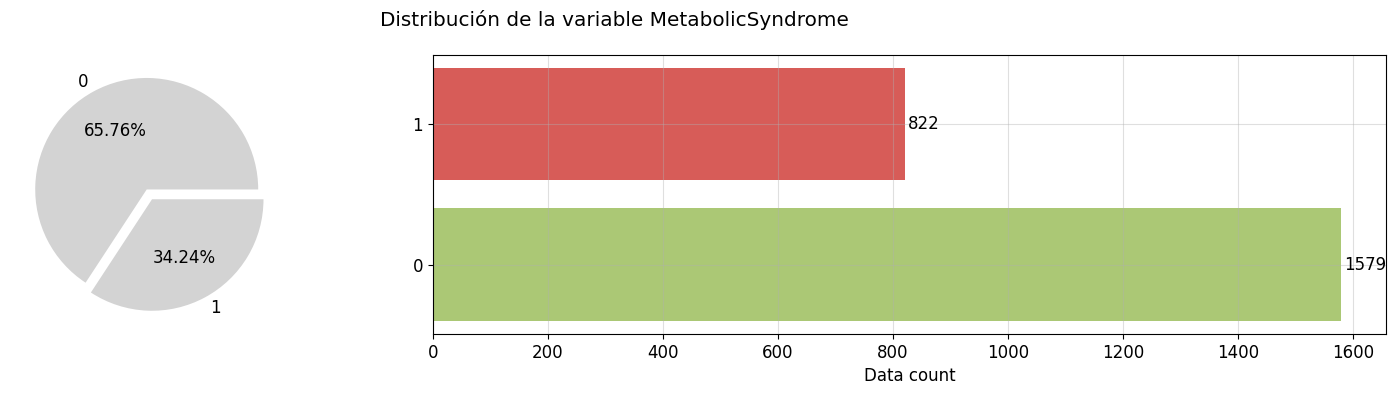

In [11]:
display_categorical("MetabolicSyndrome")

Solo un tercio del juego de datos está diagnosticado con síndrome metabólico (822 personas). El desequilibrio de clases es un hecho a tener en cuenta a la hora de construir el modelo, ya que éste podría elegir predecir únicamente la clase prevalente y acertaría así en un 65,76% de los casos.

### Variables numéricas

In [12]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.tolist()

#### Correlaciones

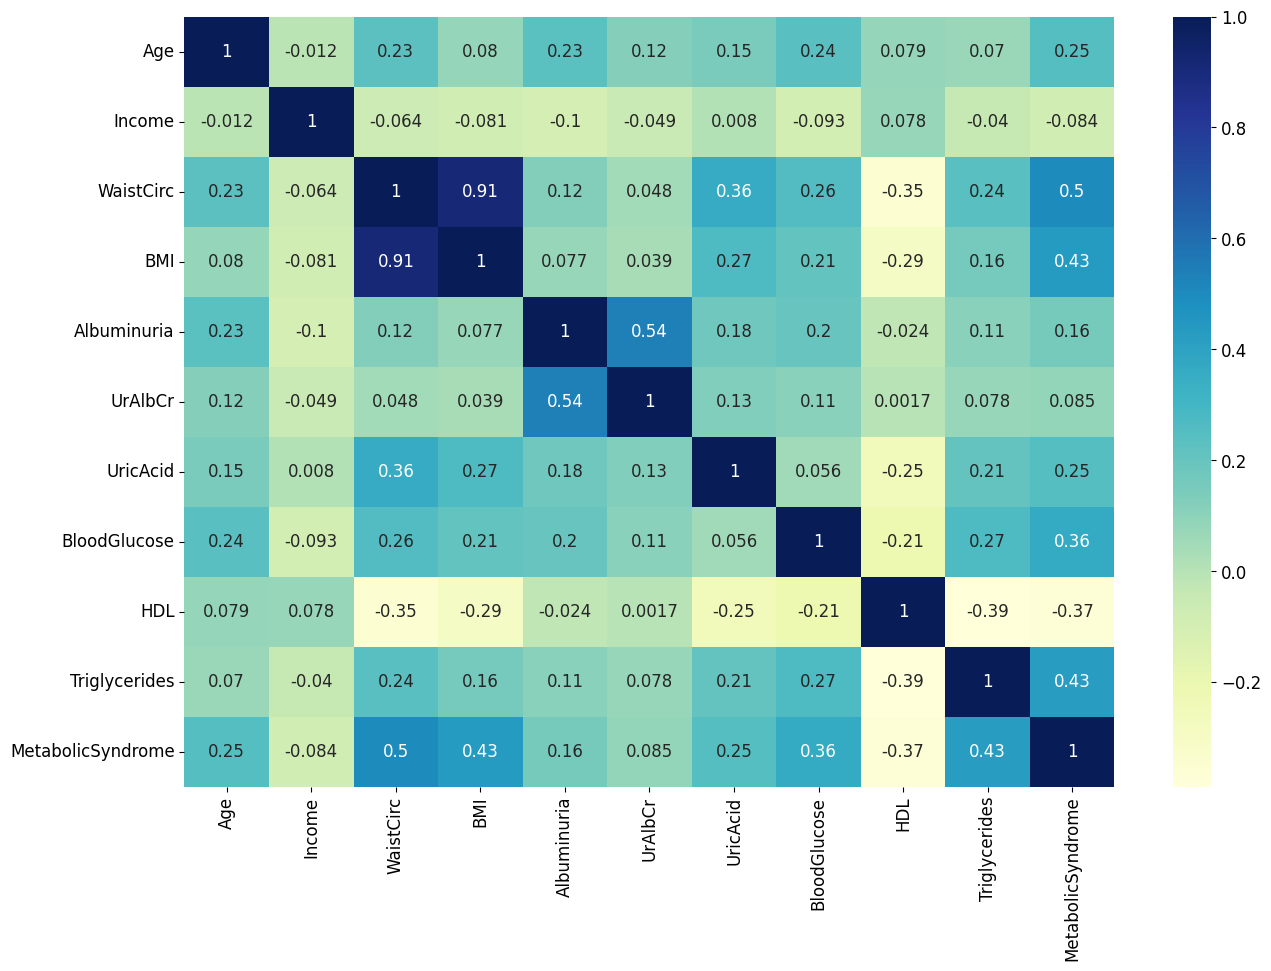

In [13]:
# Análisis de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical].corr(), annot=True, cmap="YlGnBu")
plt.show()

En muchos de los casos, las correlaciones son irrelevantes. Sin embargo, existe una excepción entre las variables *WaistCirc* y *BMI*, que están fuertemente correlacionadas (por encima de 0,9). Un hecho que cabía esperar, puesto que el índice de masa corporal es una relación entre la altura y el peso de la persona. En una población adulta, una subida significante de peso va a conllevar, en la mayoría de los casos, una circunferencia abdominal mayor, esto es, más barriga. Además, se aprecia que esta característica tiene cierta correlación con el diagnóstico de síndrome metabólico. También se destaca la relación entre *Albuminuria* y *UrAlbCr*, en la que podemos detenernos analizando los gráficos por pares:

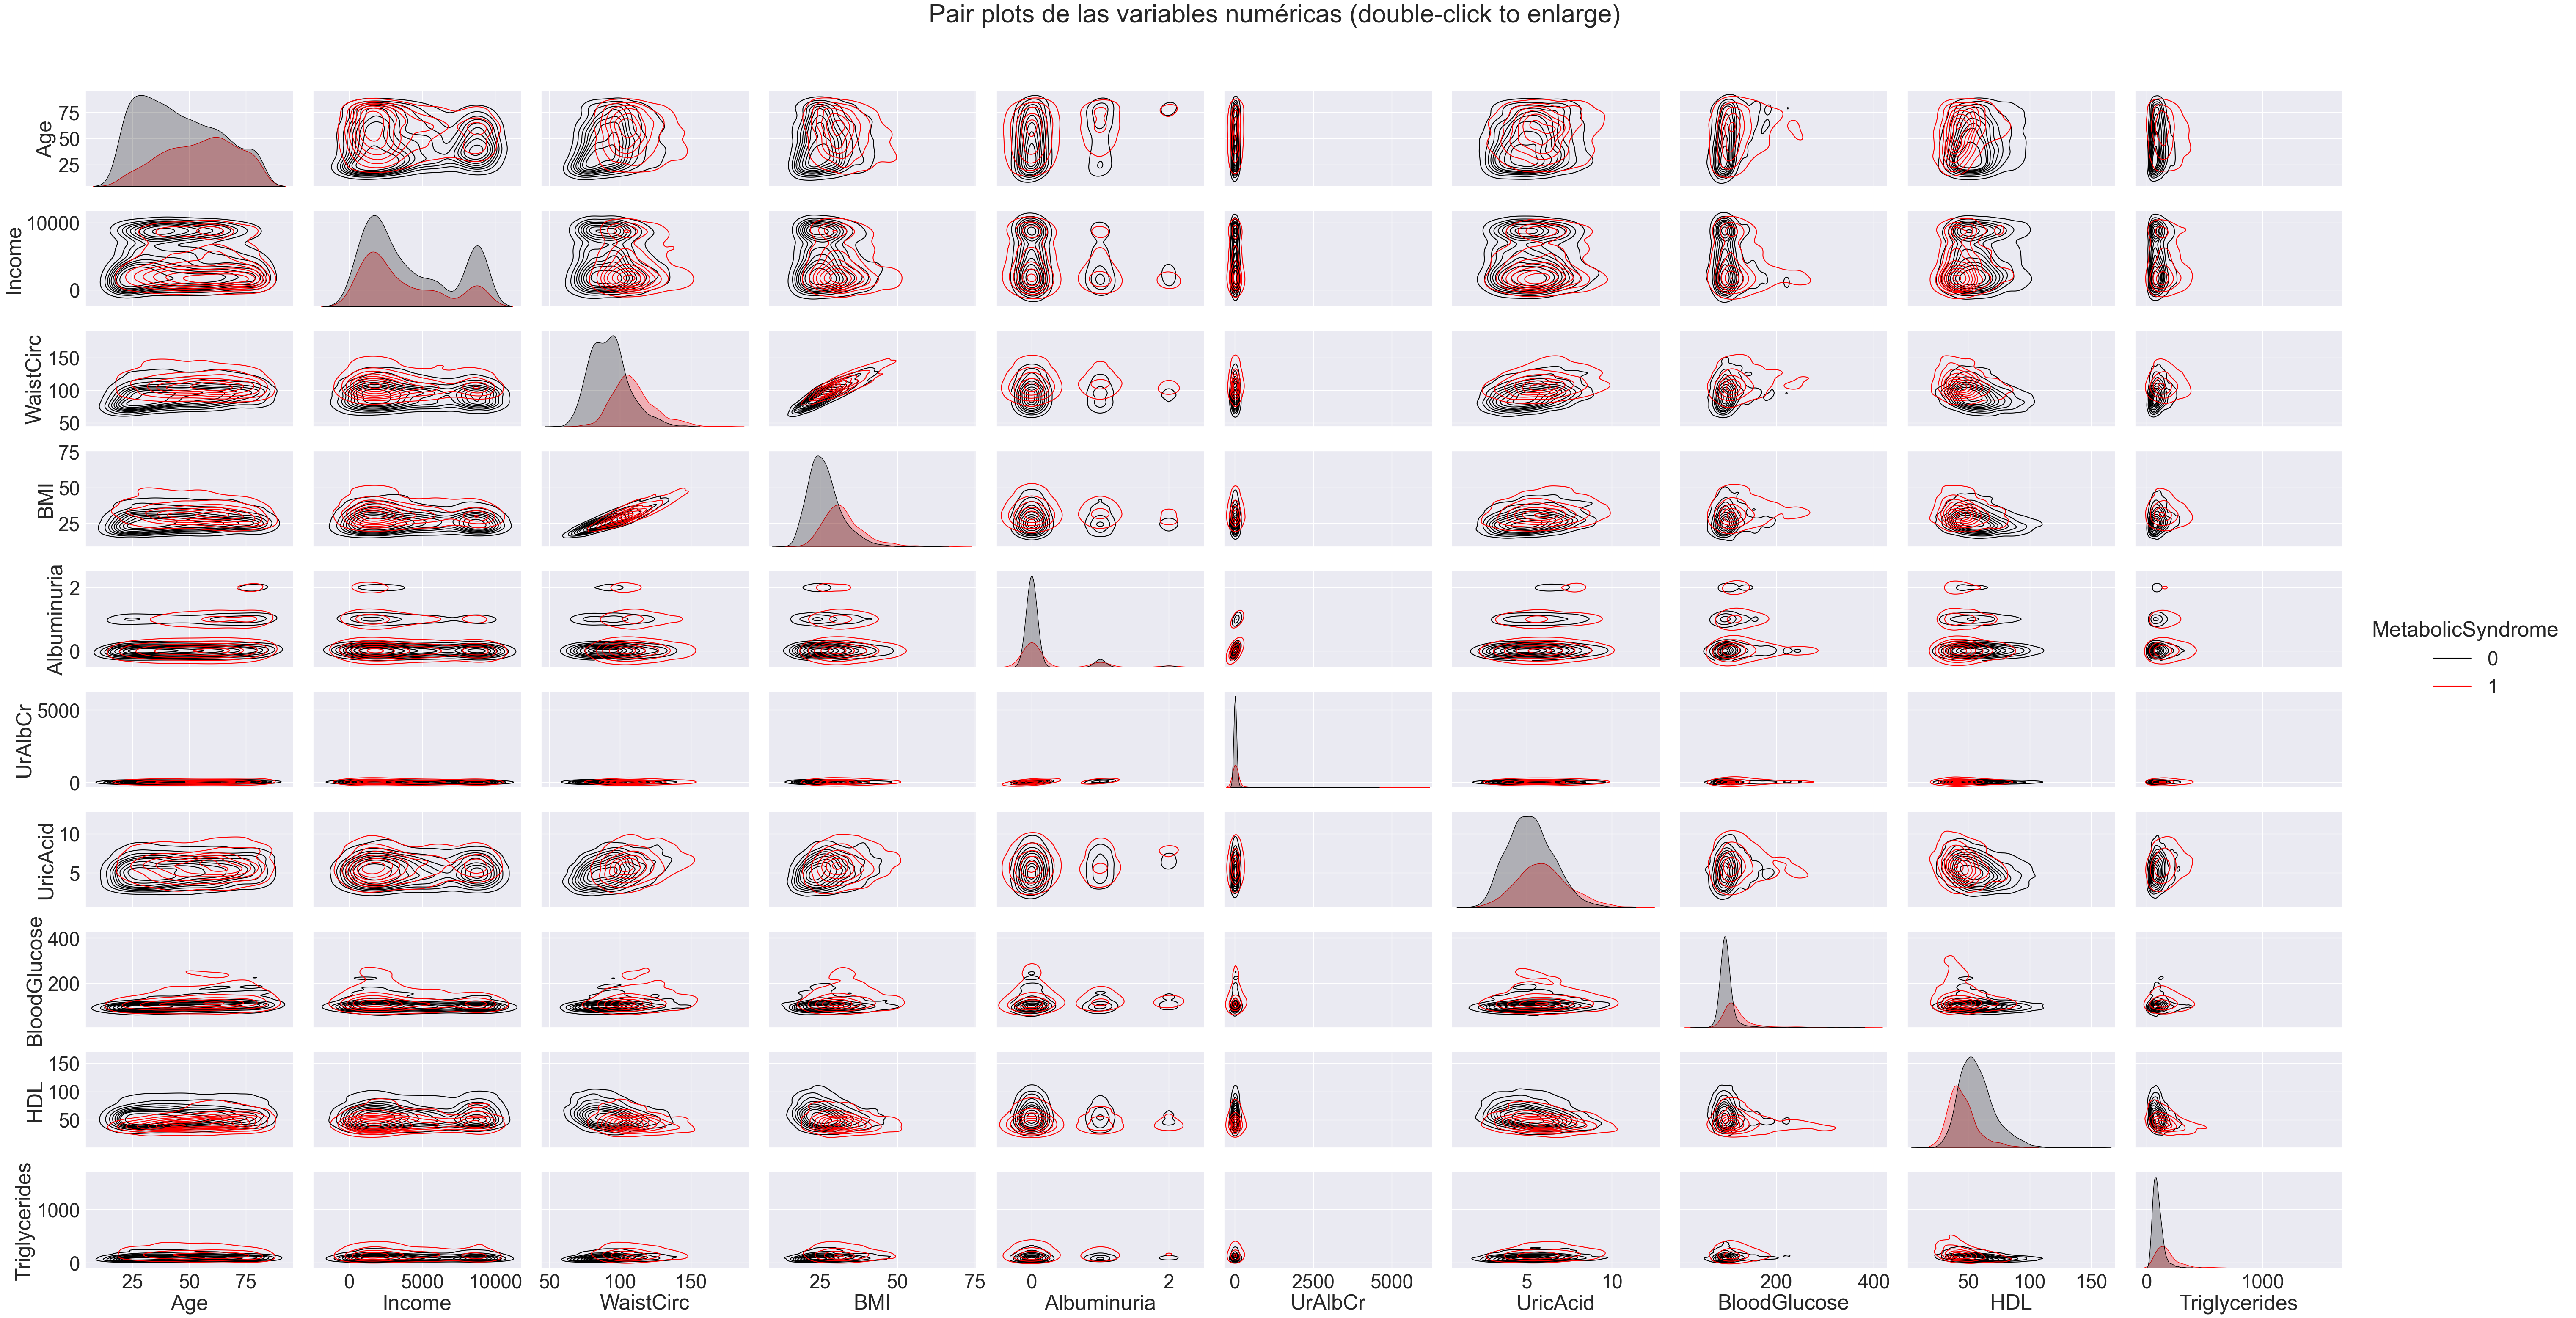

In [14]:
# Pair plot
sns.set(font_scale = 3)
    
ax = sns.pairplot(df, hue='MetabolicSyndrome', palette=['black', 'red'], hue_order=[0, 1], height=3, aspect=1.9, kind="kde")
ax.fig.suptitle('Pair plots de las variables numéricas (double-click to enlarge)', ha='center', y = 1.05)
plt.show()

sns.set(font_scale = 1) # Restauramos el tamaño de letra para el resto de gráficos

Se observa la relación obvia entre los gráficos de *BMI* y *WaistCirc*. Aquellas personas diagnosticadas con síndrome metabólico presentan valores más altos de estas dos características, aportando prácticamente la misma información si se comparan con el resto de variables. Estas personas tienden a presentar con mayor frecuencia valores también altos de *BloodGlucose* y *Triglycerides*, especialmente en los casos más extremos, al contrario que ocurre con el atributo *HDL*, cuyos niveles más altos corresponden a personas sanas. Esto es señal de cierta correlación negativa entre estas variables, cuyos gráficos permiten también detectar posibles valores atípicos, alargándose algunos contornos para atrapar a esos *outliers*.

Aunque podría haberse esperado, no se muestra correlación entre la edad y los ingresos. Para sacar alguna conclusión sobre *UrAlbCr*, utilizaremos una escala logarítmica en el eje Y para evitar que los valores de *UrAlbCr* cuando *Albuminuria* sea 0 o 1 se vuelvan indistinguibles:

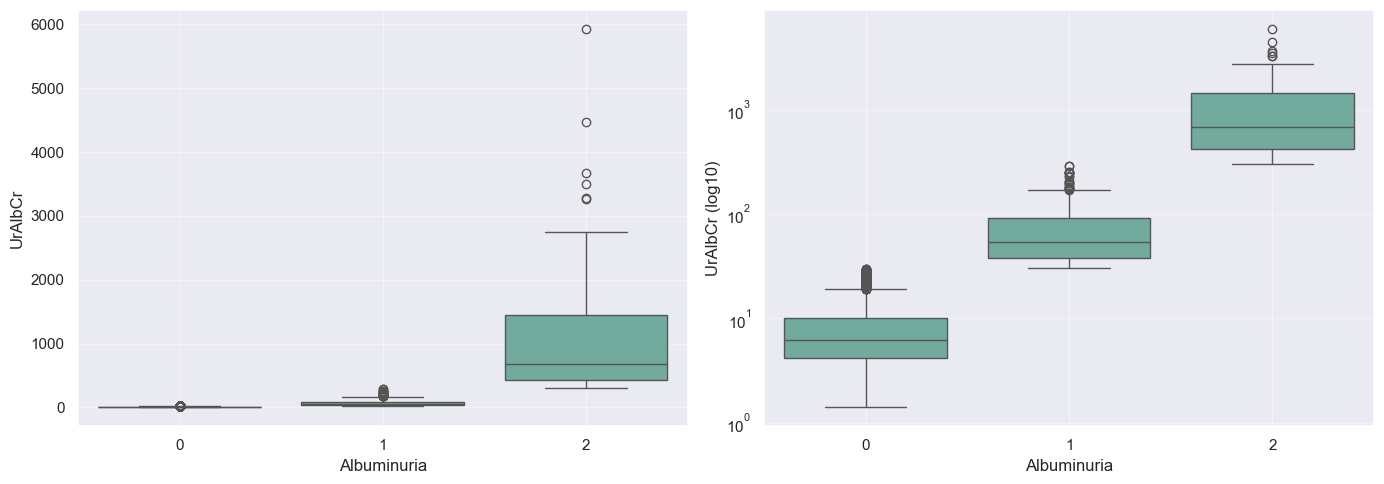

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Diagrama de cajas para albuminuria con ACR
sns.boxplot(data=df, x='Albuminuria', y='UrAlbCr', color="#69B3A2", ax=axs[0])
axs[0].grid(alpha=0.4)

# Diagrama de cajas para albuminuria con ACR con escala logarítmica
sns.boxplot(data=df, x='Albuminuria', y='UrAlbCr', color="#69B3A2", ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_ylabel("UrAlbCr (log10)")
axs[1].grid(alpha=0.4)

plt.tight_layout()
plt.show()

El diagrama de cajas deja intuir que la variable *Albuminuria* es una discretización de los valores de *UrAlbCr*. Veamos como se agrupan estos valores:

In [16]:
# Cálculo de los rangos para UrAlbCr por cada nivel de Albuminuria
alb_range = (df
             .groupby('Albuminuria')['UrAlbCr']
             .agg(min_range=('min'), max_range=('max'))
             .reset_index())

display(alb_range)

Albuminuria  min_range  max_range
0            0       1.40      29.82
1            1      30.00     289.72
2            2     301.05   5,928.00

Los valores discretos de *Albuminuria* se podrían interpretar como los resultados de un examen con tira reactiva, que indican el nivel de albúmina en la orina. La presencia de esta proteina permite detectar un daño en los riñones. Cuanta menos albúmina haya en la orina, mejor. Sin embargo, se obtiene una indicación más precisa de la cantidad de albúmina que se libera por la orina si se emplea el cociente albúmina/creatinina (ACR). Esta medida es la que se contiene en la variable *UrAlbCr*. [En la literatura](https://www.kidney.org/es/kidney-topics/albuminuria-proteinuria) se considera anormal una proporción de albúmina a creatinina en orina superior a 30 mg/g. Y efectivamente, vemos en la tabla como el nivel 1 de *Albuminuria* se obtiene a partir de un ACR de 30. A partir de 301,05 mg/g se consideraría el nivel 2, posiblemente indicando una enfermedad renal más grave.

#### Variable 'Age'

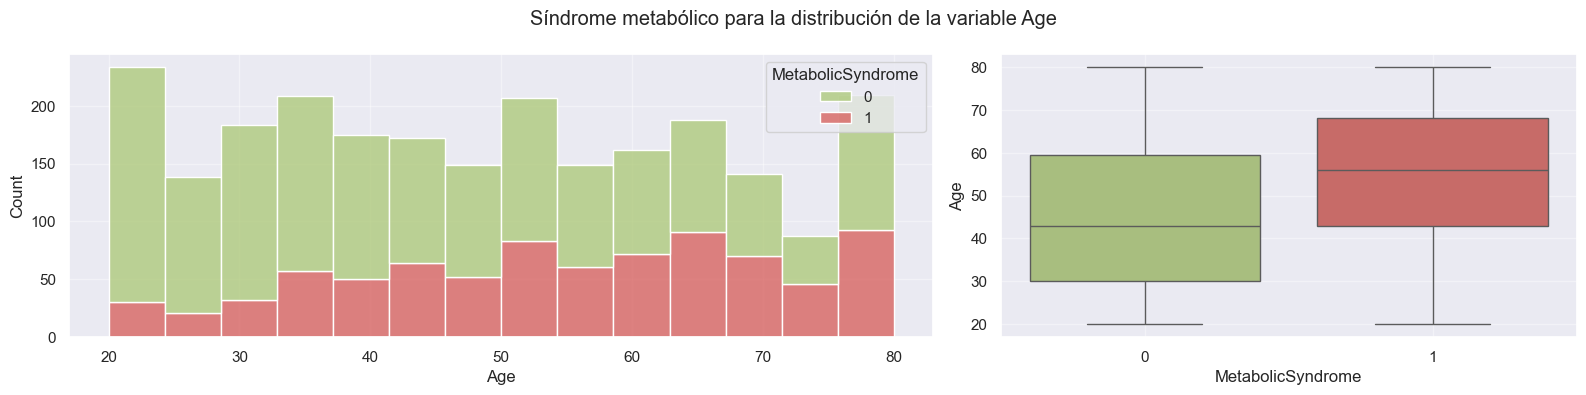

count  mean   std   min   25%   50%   75%   max
MetabolicSyndrome                                                   
0                 1,579.00 45.53 17.61 20.00 30.00 43.00 59.50 80.00
1                   822.00 54.77 16.02 20.00 43.00 56.00 68.00 80.00

In [17]:
display_numerical('Age')

La población de más edad se diagnostica positiva con más frecuencia, aunque no de manera que indique que está ligada a hacerse mayor.

#### Variable 'Income'

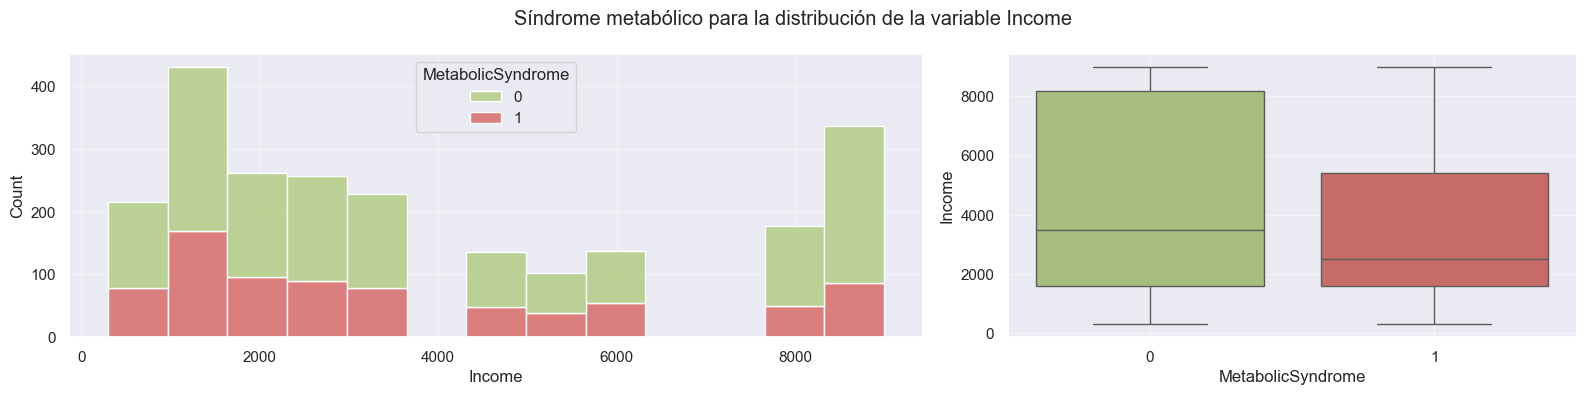

count     mean      std    min      25%      50%  \
MetabolicSyndrome                                                       
0                 1,497.00 4,184.50 3,028.24 300.00 1,600.00 3,500.00   
1                   787.00 3,664.29 2,777.56 300.00 1,600.00 2,500.00   

                       75%      max  
MetabolicSyndrome                    
0                 8,200.00 9,000.00  
1                 5,400.00 9,000.00

In [18]:
display_numerical('Income')

Hay una ligera reducción en la prevalencia del síndrome metabólico a mayores ingresos, pero no parece ser una variable muy significativa en este caso.

#### Variables 'WaistCirc' y 'BMI'

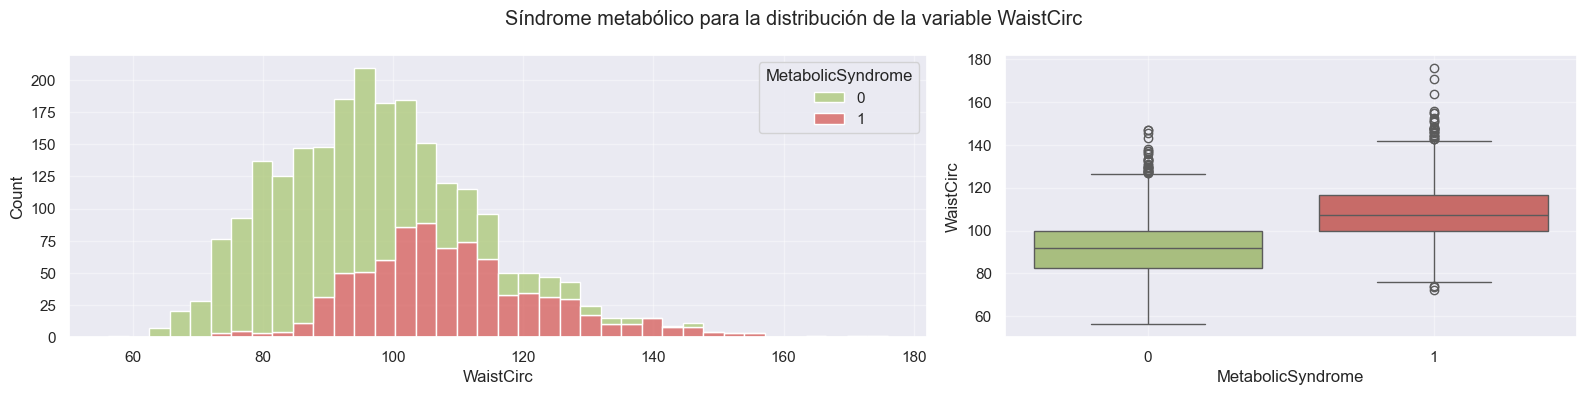

count   mean   std   min   25%    50%    75%    max
MetabolicSyndrome                                                       
0                 1,510.00  92.40 13.67 56.20 82.30  91.60 100.00 147.00
1                   806.00 109.37 14.88 72.00 99.83 107.15 116.78 176.00

In [19]:
display_numerical('WaistCirc')

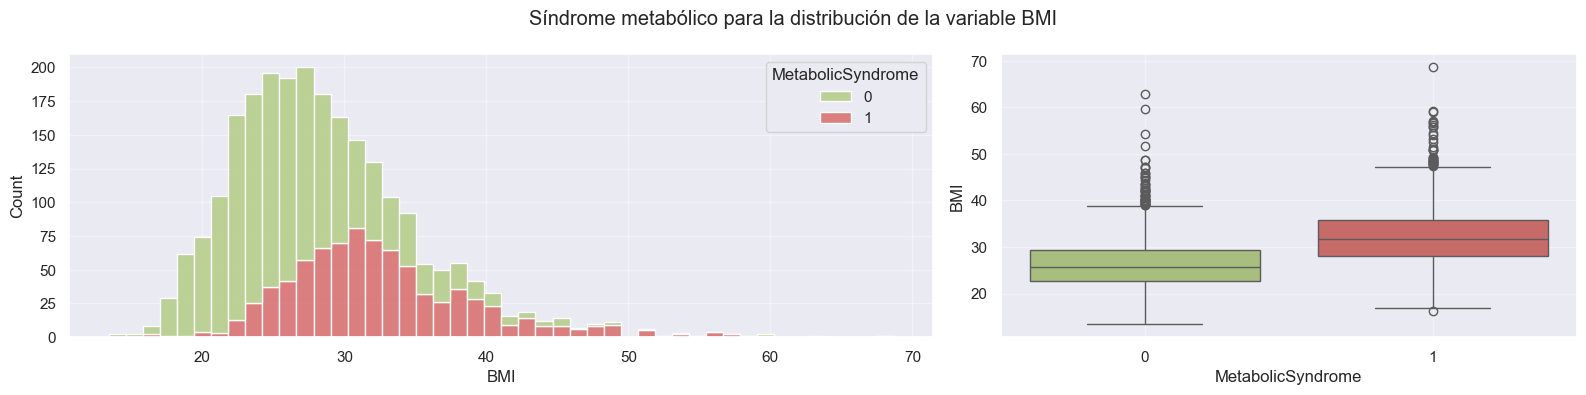

count  mean  std   min   25%   50%   75%   max
MetabolicSyndrome                                                  
0                 1,558.00 26.62 5.60 13.40 22.80 25.80 29.30 62.80
1                   817.00 32.66 6.73 16.20 28.10 31.70 35.70 68.70

In [20]:
display_numerical('BMI')

Se observa claramente como la obesidad central es un factor relevante, así como la escasa prevalencia de síndrome metabólico en personas con índices de masa corporal (*BMI*) más bajos. El desplazamiento hacia la derecha de las distribuciones de los casos con síndrome metabólico indica que hay valores para los que el BMI o la circunferencia abdominal prácticamente garantizan un diagnóstico positivo. 

#### Variable 'Albuminuria' y 'UrAlbCr'

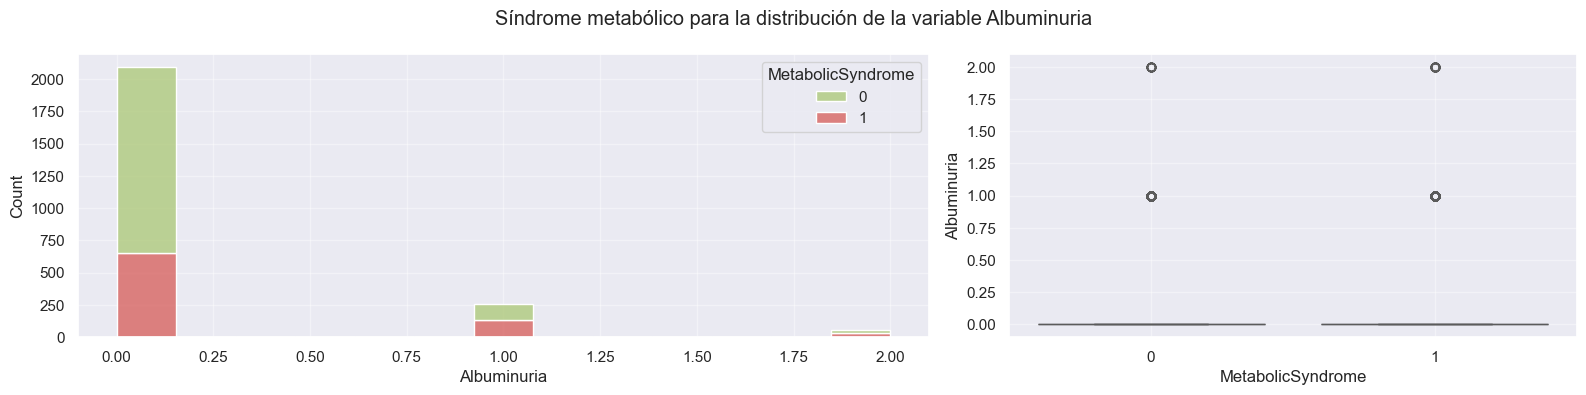

count  mean  std  min  25%  50%  75%  max
MetabolicSyndrome                                             
0                 1,579.00  0.11 0.35 0.00 0.00 0.00 0.00 2.00
1                   822.00  0.25 0.52 0.00 0.00 0.00 0.00 2.00

In [21]:
display_numerical('Albuminuria')

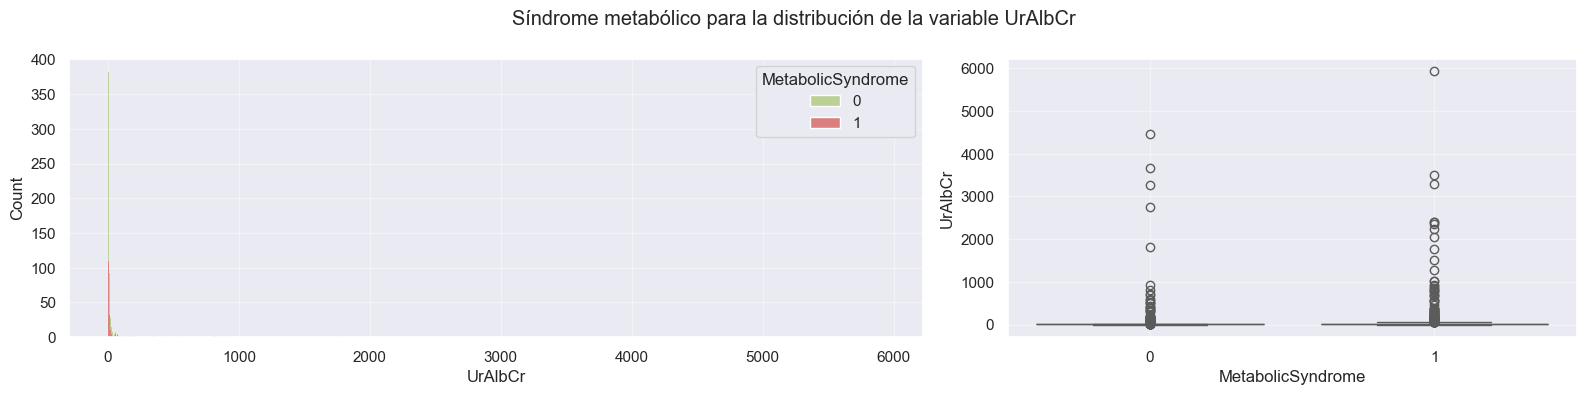

count  mean    std  min  25%  50%   75%      max
MetabolicSyndrome                                                    
0                 1,579.00 27.76 194.34 1.40 4.19 6.31 11.25 4,462.81
1                   822.00 74.11 347.84 1.41 5.20 9.14 22.71 5,928.00

In [22]:
display_numerical('UrAlbCr')

Poco podemos concluir incluso basándonos en el gráfico de *Albuminuria*, como discretización de la variable *UrAlbCr*. Al aportar la misma información desecharemos una de las dos variables. Además, este último gráfico sugiere la necesidad de normalizar los datos.

#### Variable 'UricAcid'

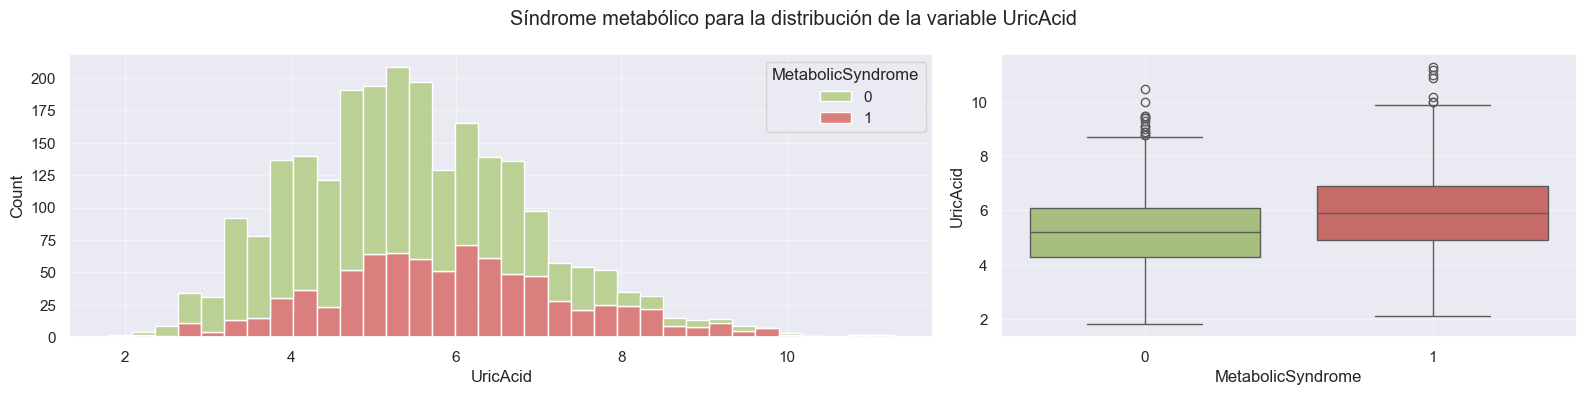

count  mean  std  min  25%  50%  75%   max
MetabolicSyndrome                                              
0                 1,579.00  5.23 1.32 1.80 4.30 5.20 6.10 10.50
1                   822.00  5.98 1.53 2.10 4.90 5.90 6.90 11.30

In [23]:
display_numerical('UricAcid')

El ácido úrico es un posible marcador de inflamación, del que se aconsejan valores inferiores a 6 mg/dL. La media en nuestro juego de datos es un saludable 5,5. 

#### Variable 'BloodGlucose'

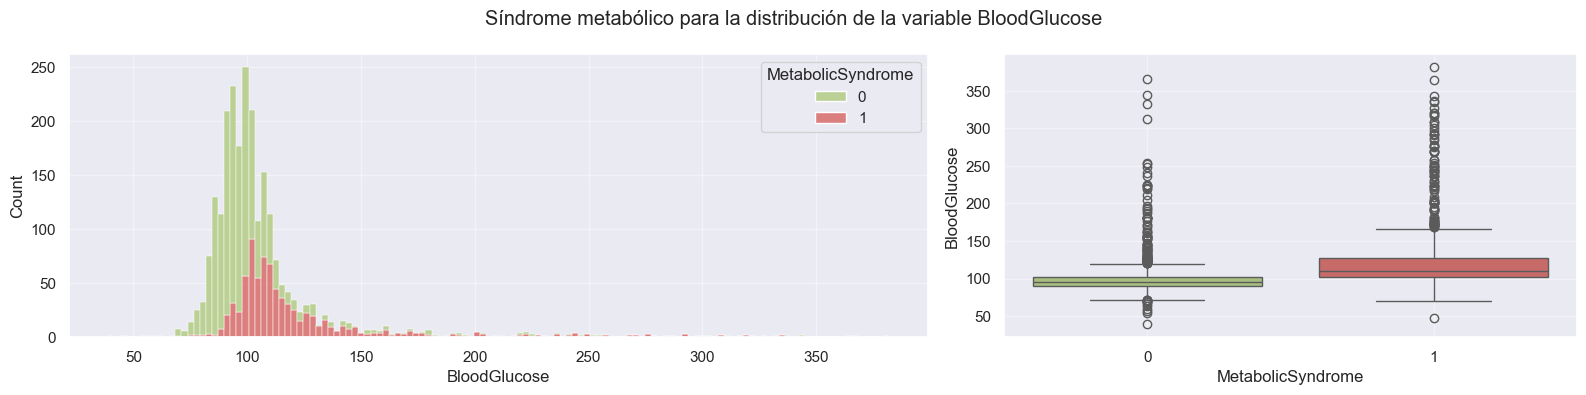

count   mean   std   min    25%    50%    75%    max
MetabolicSyndrome                                                        
0                 1,579.00  99.15 22.65 39.00  90.00  96.00 102.00 366.00
1                   822.00 125.73 45.75 47.00 102.00 110.00 127.75 382.00

In [24]:
display_numerical('BloodGlucose')

*BloodGlucose* parece ser un factor de los más relevantes entre los explorados. Por los números del resumen estadístico, deberían mostrar los resultados de un [análisis de azúcar en sangre en ayunas](https://www.labtestsonline.es/tests/glucosa), expresado en mg/dL, ya que el resto de marcadores se acostumbran a realizar en ayunas (como el perfil lipídico). Aquellos valores superiores a 126 mg/dL se interpretan como hiperglucemia, y podrían diagnosticarse como diabetes si se acompaña de otros síntomas. La media en el juego de datos (108 mg/dL) se puede considerar alta, ya que entre 100 y 125 se interpreta como prediabetes, aunque el primer cuartil supone una tolerancia normal a la glucosa. Sin embargo, este marcador es muy sensible a multitud de causas.

#### Variable 'Triglycerides'

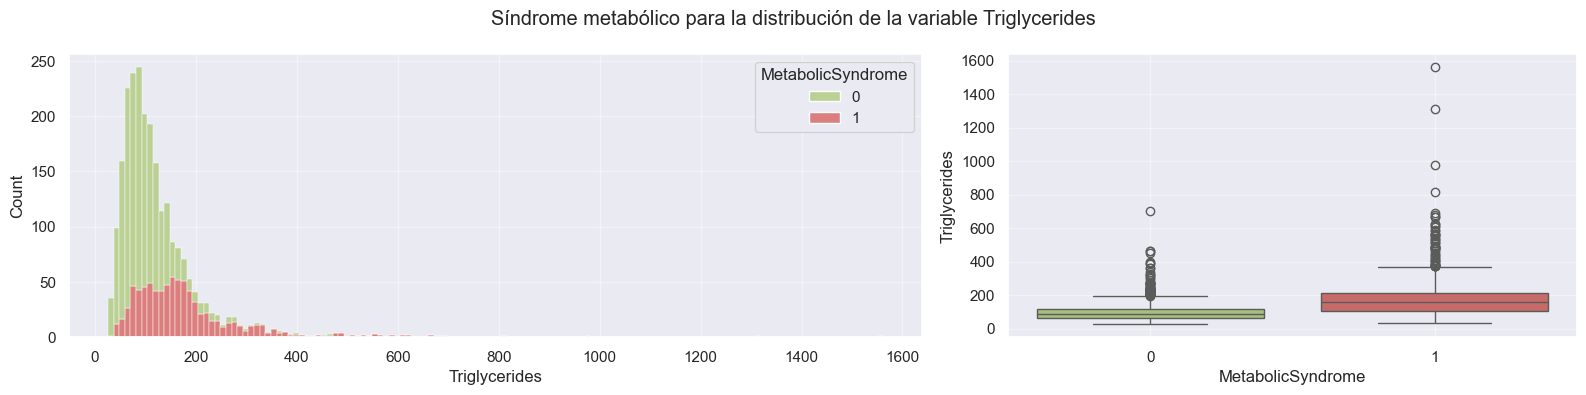

count   mean    std   min    25%    50%    75%      max
MetabolicSyndrome                                                           
0                 1,579.00  98.75  51.28 26.00  66.00  89.00 118.00   700.00
1                   822.00 184.56 129.07 31.00 108.00 157.50 212.75 1,562.00

In [25]:
display_numerical('Triglycerides')

Volvemos a apreciar una distribución desplazada a la derecha para los casos positivos. [Los triglicéridos](https://www.labtestsonline.es/tests/trigliceridos), la forma en que la grasa se almacena en el organismo, son un buen marcador de la calidad de la dieta. Los valores elevados en sangre se asocian a tener un mayor riesgo de desarrollar una enfermedad cardiovascular. La recomendación es mantenerlos por debajo de los 150 mg/dL. Valores muy altos en personas adultas se consideran aquellos superiores a 500 mg/dL. Definitivamente la media está en un nivel deseable de triglicéridos con 128 mg/dL. Hay algunos casos de niveles muy altos, e incluso algunos valores extremos que habrá que examinar más detalladamente. Este marcador es necesario contrastarlo con el del colesterol, ya que el riesgo es peor cuando los triglicéridos altos se combinan con un HDL bajo.

#### Variable 'HDL'

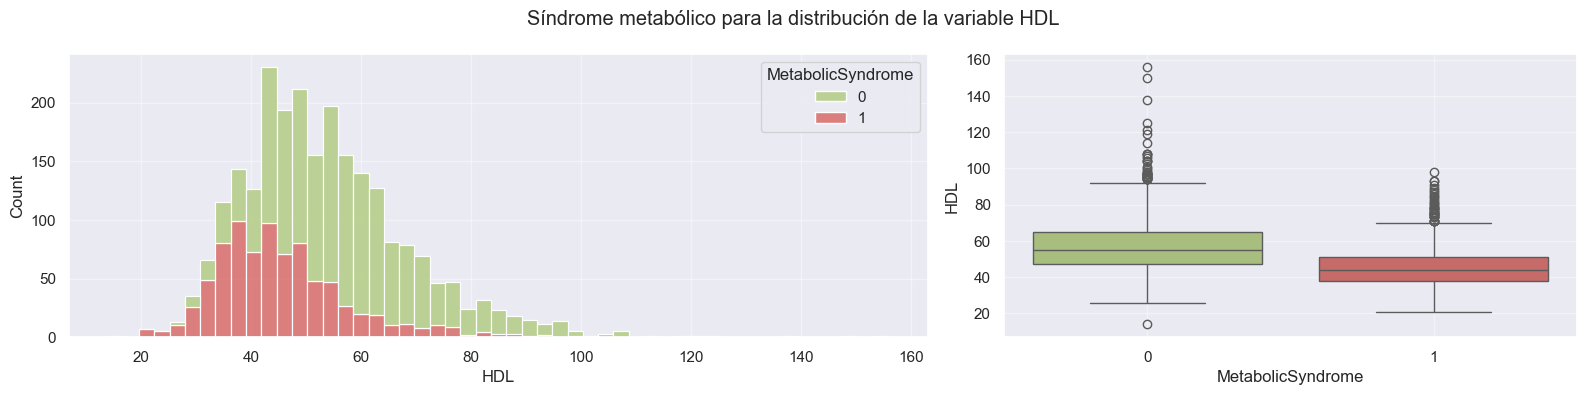

count  mean   std   min   25%   50%   75%    max
MetabolicSyndrome                                                    
0                 1,579.00 57.44 15.03 14.00 47.00 55.00 65.00 156.00
1                   822.00 45.55 12.11 21.00 38.00 44.00 51.00  98.00

In [26]:
display_numerical('HDL')

La variable *HDL* mide la concentración en sangre del [colesterol de lipoproteínas de alta densidad (HDL)](https://www.labtestsonline.es/tests/colesterol-hdl). Son un tipo de complejo formado por proteínas y grasas que transportan el colesterol en la sangre. Se consideran beneficiosas ya que eliminan el exceso de colesterol de los tejidos y lo transportan hacia el hígado para eliminarlo del organismo. Por ello, el colesterol HDL se denomina a menudo colesterol “bueno”. Es deseable que esté por encima de 60 mg/dL. Aunque se recomienda que cuanto más alto, mejor, concentraciones muy altas (más de 90 mg/dL) apuntan a que podrían estar asociadas a un mayor riesgo de infarto. La media de 53 mg/dL sitúa la población del dataset en un nivel de riesgo medio. Aparecen también algunos valores por encima de 90 mg/dL que habrá que tener en cuenta más adelante. Existe una diferencia estadísticamente significativa entre los dos grupos, que se aprecia en la distribución desplazada, esta vez, a la izquierda para valores positivos.

#### Puntuaciones ROC AUC

Podemos obtener puntuaciones ROC AUC como técnica de premodelado para evaluar la importancia de estas características numéricas. Este enfoque implica calcular la ROC AUC para cada variable individual con respecto a la objetivo, mostrando aquellas en las que las observaciones con síndrome metabólico tienen valores más altos que las que tienen valor 0 en esta variable objetivo: 

In [27]:
# Puntuaciones ROC AUC para evaluar la importancia de características
feature_scores = []

for col in numerical:       
    # Requiere que no haya valores ausentes en la variable (ni en la target)
    df_temp = df[['MetabolicSyndrome', col]].dropna()

    auc = roc_auc_score(df_temp['MetabolicSyndrome'], df_temp[col]) 
    if auc < 0.5: # in case the feature is negatively correlated with the target
        auc = roc_auc_score(df_temp['MetabolicSyndrome'], -df_temp[col])
    feature_scores.append((col, auc))

columns = ['Feature', 'ROC_AUC']
df_scores = pd.DataFrame(feature_scores, columns=columns)
df_scores = df_scores.sort_values(by=['ROC_AUC'], ascending=False).reset_index(drop=True)

display(df_scores)

Feature  ROC_AUC
0   MetabolicSyndrome     1.00
1        BloodGlucose     0.82
2           WaistCirc     0.81
3       Triglycerides     0.79
4                 BMI     0.78
5                 HDL     0.75
6                 Age     0.65
7            UricAcid     0.64
8             UrAlbCr     0.62
9         Albuminuria     0.56
10             Income     0.55

Podemos contrastar ahora nuestras observaciones con respecto a *BloodGlucose*, *WaistCirc* y *Triglycerides*, con *BMI* y *HDL* muy cercanos, como marcadores más importantes en el diagnóstico de síndrome metabólico.

### Variables categóricas

In [28]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()

#### Variable 'Sex'

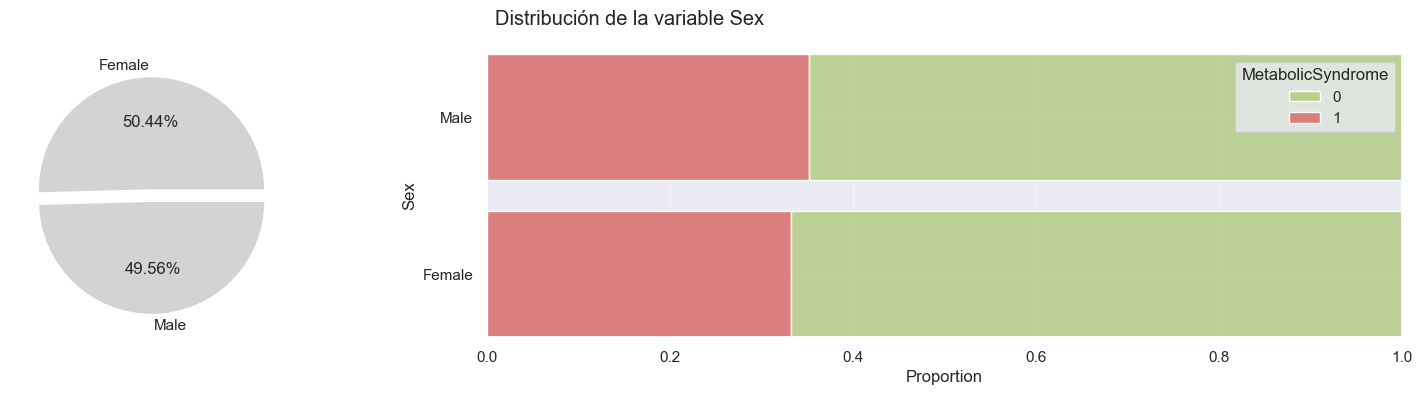

In [29]:
display_categorical("Sex")

No se observa una diferencia por *Sex* en la prevalencia de síndrome metabólico.

#### Variable 'Marital'

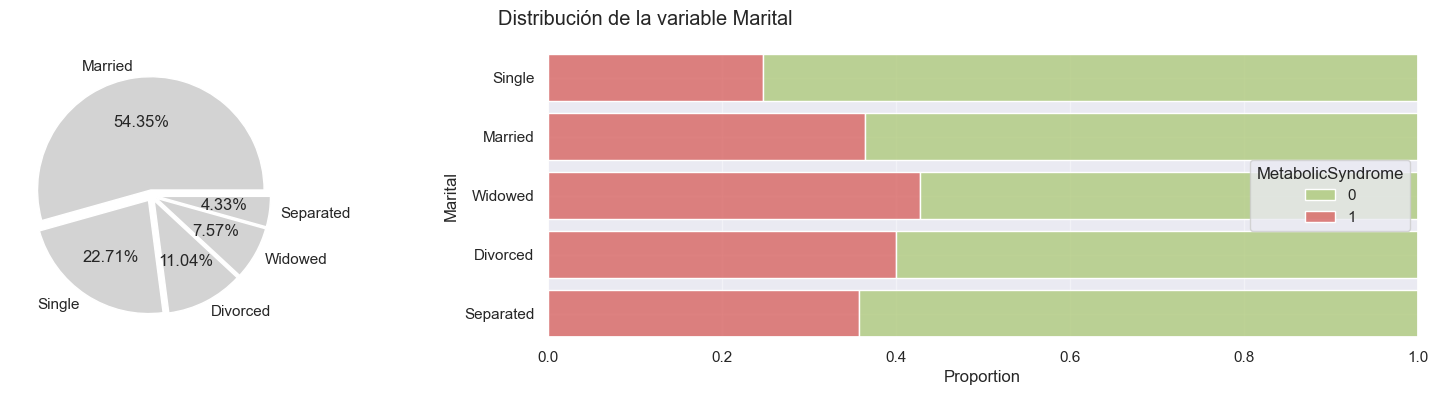

In [30]:
display_categorical("Marital")

Hay una ligera reducción en la prevalencia del síndrome metabólico en personas solteras, pero puede deberse a la misma relación observada por edad, al corresponderse la mayoría de éstas con la población más joven:

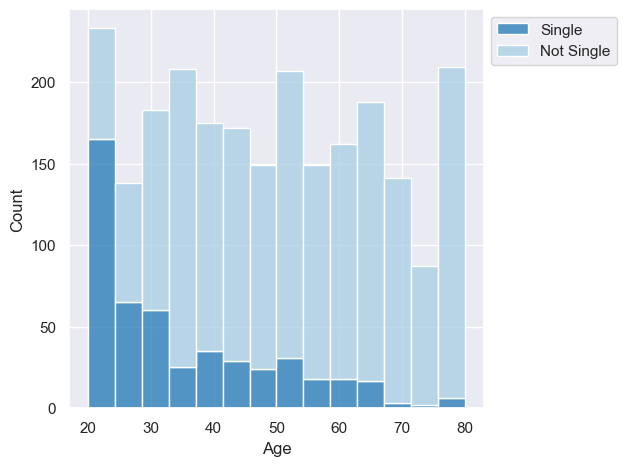

In [31]:
# Histograma de Age por estado civil Single 
fig = sns.histplot(data=df, x=df['Age'], hue=df['Marital'] == "Single", multiple='stack', palette="Paired")
fig.legend(['Single', 'Not Single'])
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))    
plt.tight_layout(pad=1)
plt.show()

#### Variable 'Race'

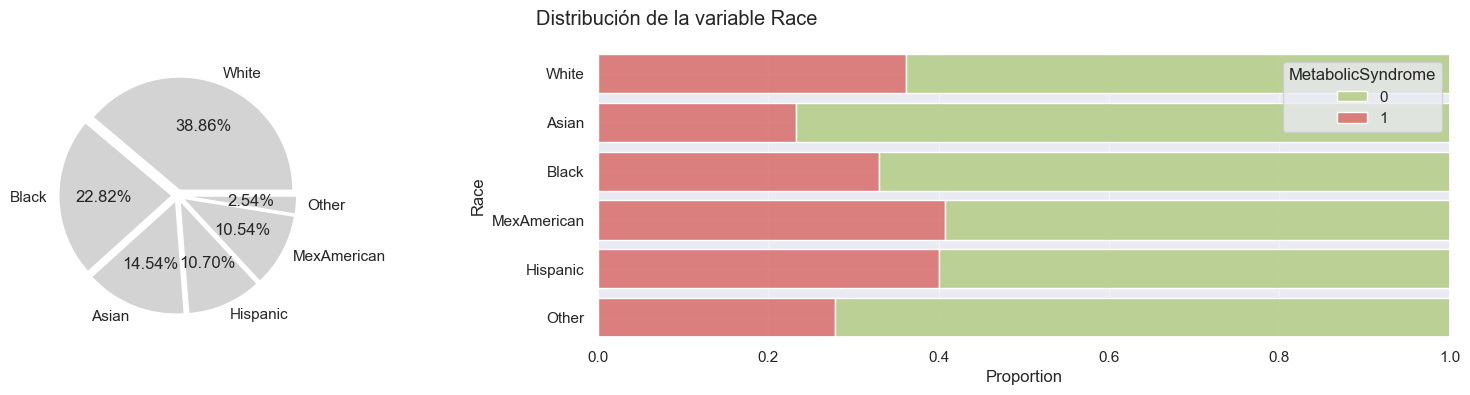

In [32]:
display_categorical("Race")

La prevalencia de síndrome metabólico varía por población y, por ejemplo, para comunidades mexicanas e hispanas ese número es mayor que para poblaciones asiáticas. Puede ser interesante observar la diferencia de la variable *WaistCirc* por sexo y etnia:

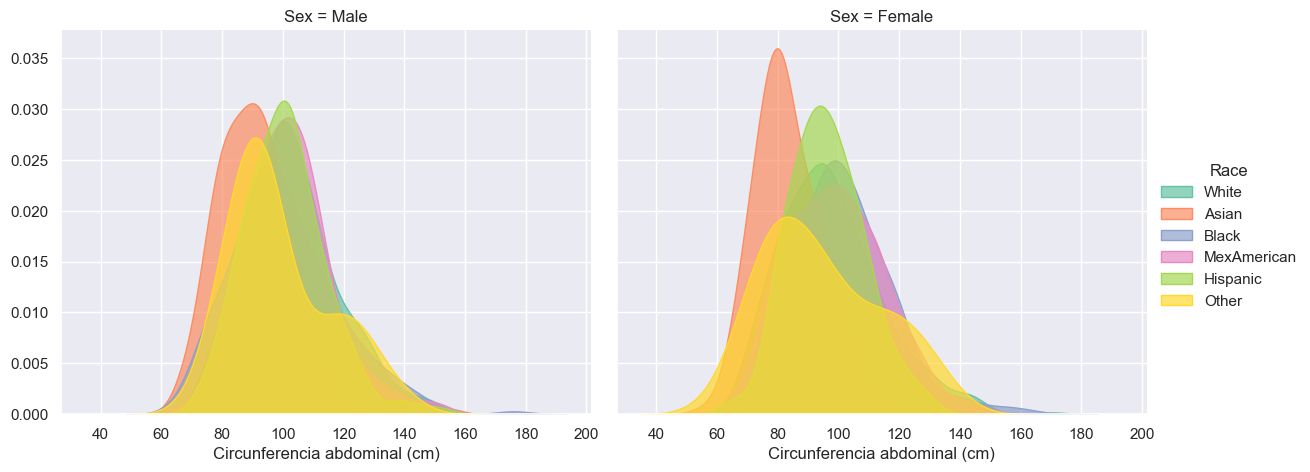

In [33]:
# Densidad de Race por WaistCirc, separados por Sex
fig = sns.FacetGrid(df, col="Sex", hue="Race", height=5, aspect=1.2, palette="Set2")
fig.map(sns.kdeplot, "WaistCirc", fill=True, alpha=0.7)

fig.set_axis_labels("Circunferencia abdominal (cm)", "")
fig.add_legend()
plt.subplots_adjust(top=0.9)
plt.show()

Que muestra a las mujeres con una media en conjunto menor que la de los hombres, así como la de la población asiática en general. Y justamente las curvas de las etnias que estan más desplazadas a la derecha (mayor obesidad central), son las correspondientes con *Hispanic* y *MexAmerican*. Estas diferencias hacen que la [obesidad central esté definida](https://gastropedia.pub/es/cirugia/obesidad-concepto-consecuencias-y-clasificacion/) como una circunferencia abdominal (*WaistCirc*) mayor o igual a 102 cm en hombres y 88 cm en mujeres. Así en comunidades asiáticas, la obesidad central se definiría por 90 cm en los hombres y 80 cm en mujeres, como medida de corrección a lo observado.

## Tareas de limpieza y acondicionado

### Valores nulos

Tendremos que decidir como tratar valores ausentes para los atributos *Income* (117), *WaistCirc* (85), *BMI* (26) y *Marital* (208). Para este último, rellenamos los valores en blanco con la palabra “Unknown” (desconocido), puesto que sería ingenuo tratar de inferir el estado civil de las personas a través de la información de la que se dispone.

In [34]:
# Rellenamos con "Unknown" aquellos valores ausentes de Marital
df['Marital'] = df['Marital'].fillna('Unknown')

Para el resto, usaremos técnicas de imputación para completar los “huecos”, como la de los vecinos más cercanos y la regresión lineal. Sin embargo, para evitar [la fuga de datos](https://es.wikipedia.org/wiki/Fuga_(aprendizaje_autom%C3%A1tico)) (*data leakage*), aplicaremos estas imputaciones una vez hayamos dividido los datos en conjuntos de entrenamiento y de evaluación. Lo que sí haremos ahora es eliminar aquellas observaciones donde ambas variables, *WaistCirc* y *BMI*, sean desconocidas, ya que hemos visto que la obesidad central es una de las características clave del síndrome metabólico.

In [35]:
# Número de observaciones donde las variables WaistCirc y BMI coinciden con valores ausentes
missing_rows = len(df[(df['WaistCirc'].isna()) & (df['BMI'].isna())])
# Eliminamos estas filas
df = df[~((df['WaistCirc'].isna()) & (df['BMI'].isna()))]

print(f"Se eliminaron {missing_rows} observaciones, donde estaban ausentes los valores tanto de WaistCirc como de BMI.")

Se eliminaron 21 observaciones, donde estaban ausentes los valores tanto de WaistCirc como de BMI.


### Outliers

Para explorar los valores extremos de aquellos marcadores de los que teníamos interés utilizaremos el método IQR:

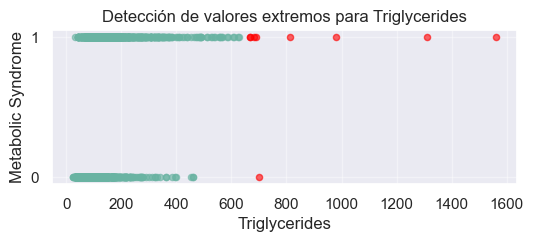

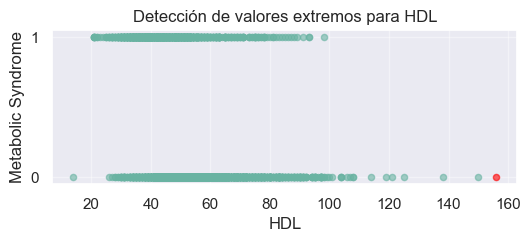

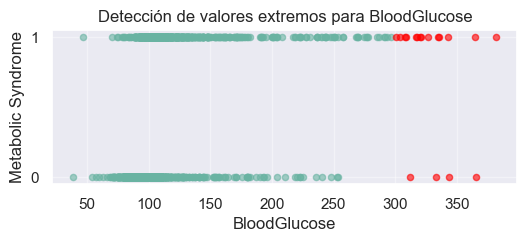

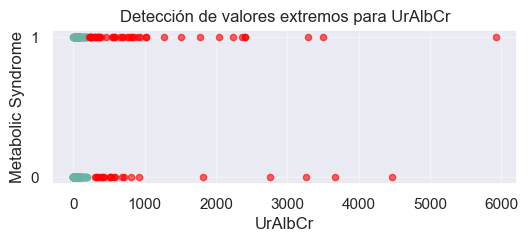

In [36]:
# Detección de outliers con el método IQR
def plot_outliers(df, feature):
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3 - Q1

    min_iqr = Q1 - 1.5 * IQR
    max_iqr = Q3 + 1.5 * IQR
    
    outliers = (df[feature] < min_iqr) | (df[feature] > max_iqr)
    inliers = ~outliers

    # Visualizamos los datos
    plt.figure(figsize=(6, 2))
    plt.scatter(df[inliers][feature], df[inliers]['MetabolicSyndrome'], label="Inliers", alpha=0.6, color='#69B3A2', s=20)
    plt.scatter(df[outliers][feature], df[outliers]['MetabolicSyndrome'], label="Outliers", alpha=0.6, color='red', s=20)

    plt.title(f'Detección de valores extremos para {feature}')
    plt.xlabel(feature)
    plt.ylabel("Metabolic Syndrome")
    plt.yticks([0, 1])  # Set y-axis ticks to only show 0 and 1
    plt.grid(alpha=0.4)
    plt.show()

for col in ['Triglycerides', 'HDL', 'BloodGlucose', 'UrAlbCr']:
    plot_outliers(df, col)

Careciendo de la expertise necesaria para interpretar estos resultados, preferimos no eliminar ninguna fila, puesto que estos valores extremos podrían aportar cierta información relevante. Por ejemplo, un *outlier* como los más de 1500 mg/dL de triglicéridos podría indicar una enfermedad del pancreas o renal, más que un error en el marcador.

### Guardar los datos

Por último, decidiremos continuar con la variable *UrAlbCr* en vez de su discretización almacenada en *Albuminuria*. Por lo tanto eliminamos esta última y, a continuación, guardamos el conjunto de datos con los cambios realizados.

In [37]:
# Elinimamos variable Albuminuria 
df.drop('Albuminuria', axis=1, inplace=True)

In [38]:
df.to_csv("metabolic_syndrome_clean.csv", index=False)

## Conclusión

Hemos explorado un juego de datos con medidas demográficas y clínicas de 2401 personas, junto con una variable objetivo que señala la presencia o ausencia de síndrome metabólico en cada una de ellas. Mujeres y hombres están representados prácticamente por igual, con un rango de edad de los 20 a los 80 años. Se dispone también de información sobre la población étnica a la que pertenecen, el estado civil y los niveles de ingresos, ya que puede que este conocimiento derive alguna conclusión en relación al síndrome metabólico. El resto de atributos se corresponde con marcadores analíticos en sangre y orina.

Pudimos constatar que el sobrepeso y la obesidad están estrechamente relacionados con el síndrome metabólico. Aunque éste también afecta a personas con peso normal en presencia de ciertos marcadores elevados. Este es el caso de la hipertrigliceridemia, niveles muy altos de triglicéridos, siendo uno de los predictores más destacados. Otro marcador que se asocia de manera sólida con el diagnóstico sería el de diabetes, valores de azúcar en sangre superiores a 125 mg/dL. Una representación de los tres marcadores comentados permite ver este resumen:

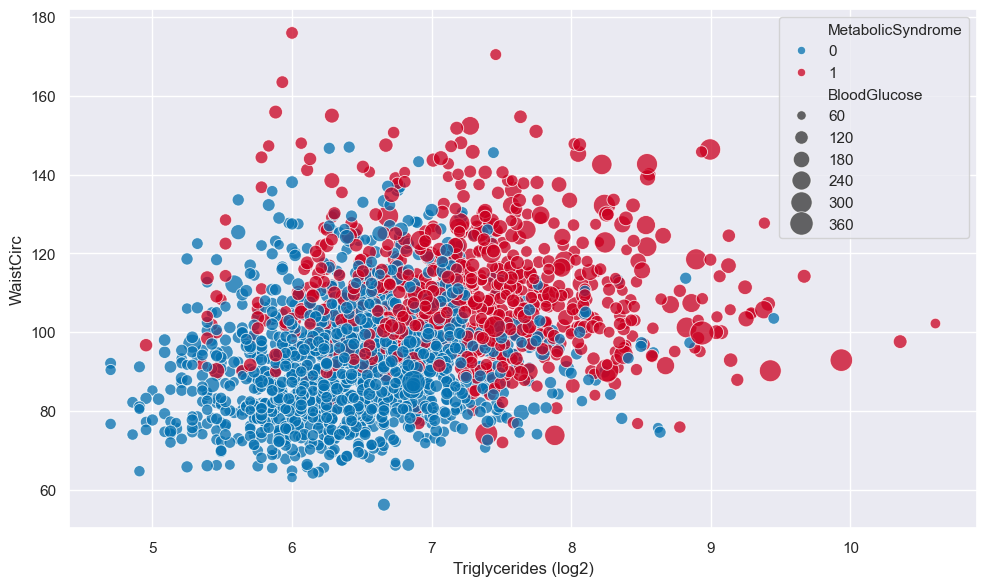

In [39]:
# Visualizamos WaistCirc, Triglycerides y BloodGlucose por clase
plt.figure(figsize=(10, 6))

# Triglycerides con Log2 transform del eje x
sns.scatterplot(data=df,
    x=np.log2(df['Triglycerides']),
    y='WaistCirc',
    size='BloodGlucose',
    hue='MetabolicSyndrome',
    palette=['#0571B0', '#CA0020'],
    alpha=0.75,
    sizes=(30, 300)
)
plt.xlabel("Triglycerides (log2)")
plt.tight_layout(pad=1)
plt.show()

La mayoría de estos marcadores tenían datos para todos los individuos, a excepción de los referidos al índice de masa corporal y a la circunferencia de la cintura, que deberemos tratar durante el preprocesado de los datos. Además, se eliminaron dos columnas que contenían datos redundantes o no aportaban información.

Llegados a este punto, tenemos la necesidad de abordar la naturaleza ligeramente desequilibrada de la variable objetivo, pues el número de muestras de una clase es prácticamente el doble del número de muestras de la otra. Esto es, tenemos 1560 personas "sanas" en comparación con las 820 diagnosticadas con síndrome metabólico. Para tratar con este desequilibrio ajustaremos el umbral de decisión, usaremos métricas más apropiadas que la exactitud a la hora de evaluar el modelo y probaremos algoritmos que actúan mejor en estas circunstancias, como los de la familia *ensemble learning*. Corregir el desequilibrio de clases con algún tipo de muestreo no siempre es necesario e incluso [puede resultar perjudicial para los modelos de predicción clínica que tienen como objetivo producir estimaciones de riesgo fiables de forma individual](https://arxiv.org/abs/2404.19494). Además, la aplicación de estas ténicas o un PCA, para la reducción de la dimensionalidad, ponen trabas a la interpretabilidad del modelo y tampoco garantizan unos resultados por los que salga a cuenta aplicarlos dada la naturaleza del juego de datos.

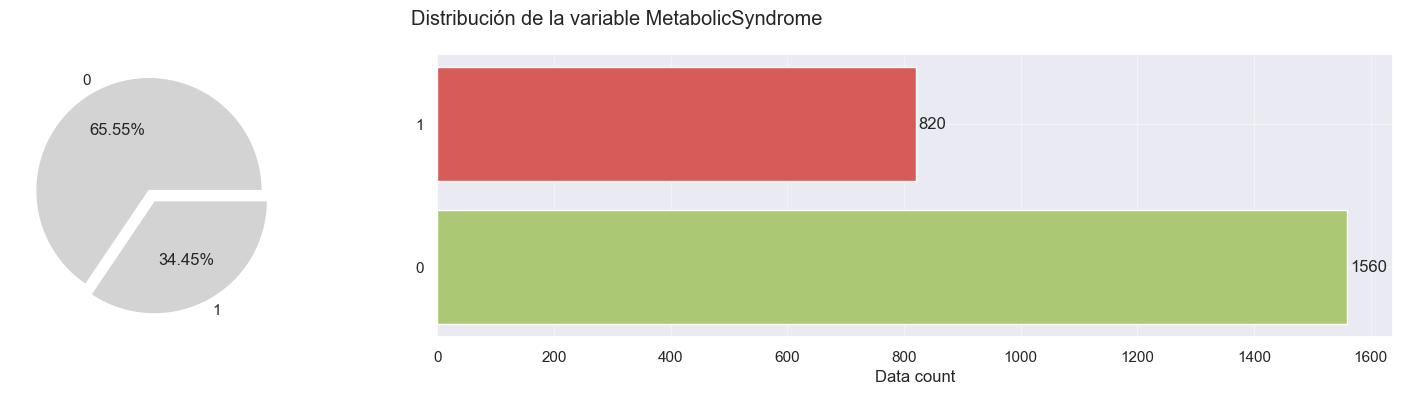

In [40]:
display_categorical('MetabolicSyndrome')

## Gráficos extra para incluir en la memoria

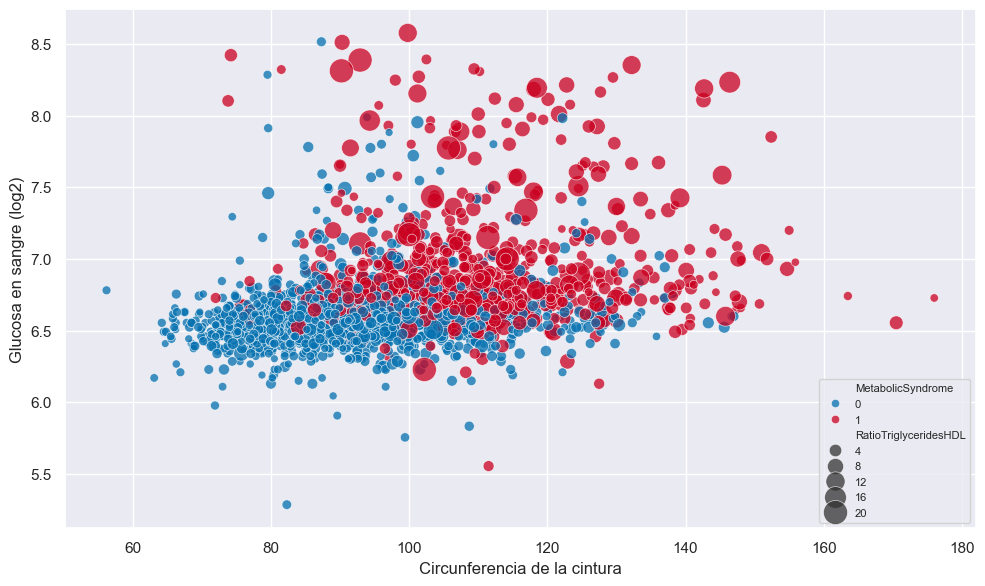

In [41]:
# Generamos un gráfico para poder incluir en la memoria que de alguna manera incluya
# los que consideramos son los mejores predictores: BloodGlucose, Triglycerides, WaistCirc, HDL

# Visualizaremos la relación triglicéridos/HDL sobre los ejes de la circunferencia abdominal y azúcar en sangre
df['RatioTriglyceridesHDL'] = (df['Triglycerides'] / df['HDL']).round(1).clip(upper=20)

plt.figure(figsize=(10, 6))

sns.scatterplot(data=df,
    x='WaistCirc', 
    y=np.log2(df['BloodGlucose']),
    size='RatioTriglyceridesHDL',
    hue='MetabolicSyndrome',
    palette=['#0571B0', '#CA0020'],
    alpha=0.75,
    sizes=(30, 300)
)

plt.xlabel("Circunferencia de la cintura")
plt.ylabel("Glucosa en sangre (log2)")
plt.legend(fontsize=8, loc='lower right')
plt.tight_layout(pad=1)
plt.show()